In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
import pickle as pkl
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split


pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/umanglilha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/umanglilha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
df = pd.read_csv('books_task.csv').drop(columns=['Unnamed: 0'])

In [3]:
def handle_outliers(df, cols_to_clip):
    """Handle outliers using percentile-based clipping (Wisorization)."""
    for col in cols_to_clip:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)
    return df

def clean_text(text):
    """Clean text by removing punctuation, special characters, and stop words."""
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE) # Remove punctuation and special characters
    text = text.lower() # Convert text to lowercase
    text = text.replace('\t', ' ') # Replace tabs with a single space
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    tokens = text.split() # Tokenize the text
    tokens = [lemmatizer.lemmatize(token) for token in tokens]    # Lemmatize each word as noun (eg. cars)
    tokens = [lemmatizer.lemmatize(token, "v") for token in tokens] # Lemmatize each word as a verb (eg. running -> run)
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    text = " ".join(tokens) # Join the cleaned words back into a single string
    return text

def round_values(df, n=2, cols=None):
    """Round off values in specified columns to n decimal places."""
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for column in numerical_cols:
        df[column] = df[column].round(n)
    return df

def get_w2v_embedding(text, w2v_model):
    """Get the average word2vec embedding for a given text."""
    words = text.split()
    valid_words = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if not valid_words:  # Check if the list is empty
        return np.zeros(w2v_model.vector_size)  # Return a zero vector if no valid words
    embedding = np.mean(valid_words, axis=0)
    return embedding

def preprocess_text_feature(series):
    """Convert to lowercase and remove unnecessary whitespace."""
    return series.str.lower().str.strip().str.replace(r'\s+', ' ', regex=True)

def get_main_author(authors, impacts):
    """Get the main author for a given book."""
    if not authors or not impacts:
        return None
    max_impact_index = impacts.index(max(impacts))
    return authors[max_impact_index]

## Data Cleaning and feature engineering for Title and description
- create a new column for the length of the title and description
- get the word2vec embedding for the title and description combined.
- create a new column for the word2vec embedding for the title and description combined.



In [4]:
df[['description', 'Title']] = df[['description', 'Title']].fillna('')
df['desc_length'] = df['description'].apply(len)
df['title_length'] = df['Title'].apply(len)
df = handle_outliers(df, ['desc_length', 'title_length']) # handle outliers(winsorization)
df = round_values(df, n=0, cols=['desc_length', 'title_length']) # round off the values to the nearest integer
df[['desc_length','title_length']].describe()

,desc_length,title_length
count,138724.000000,138724.000000
mean,610.227754,46.325942
std,570.052399,28.642529
min,0.000000,7.000000
25%,169.000000,23.000000
50%,410.000000,41.000000
75%,945.000000,63.000000
max,2543.000000,140.000000


In [5]:
# clean the title and description
df['desc_clean'] = df['description'].apply(clean_text)
df['title_clean'] = df['Title'].apply(clean_text)
df[['Title','title_clean', 'description', 'desc_clean']].head(2)

,Title,title_clean,description,desc_clean
0,Its Only Art If Its Well Hung!,art well hang,,
1,Dr. Seuss: American Icon,dr seuss american icon,"Philip Nel takes a fascinating look into the key aspects of Seuss's career - his poetry, politics, art, marketing, and place in the popular imagination."" ""Nel argues convincingly that Dr. Seuss is one of the most influential poets in America. His nonsense verse, like that of Lewis Carroll and Edward Lear, has changed language itself, giving us new words like ""nerd."" And Seuss's famously loopy artistic style - what Nel terms an ""energetic cartoon surrealism"" - has been equally important, inspiring artists like filmmaker Tim Burton and illustrator Lane Smith. --from back cover",philip nel take fascinate look key aspect seusss career poetry politics art market place popular imagination nel argue convincingly dr seuss one influential poet america nonsense verse like lewis carroll edward lear ha change language give u new word like nerd seusss famously loopy artistic style nel term energetic cartoon surrealism ha equally important inspire artist like filmmaker tim burton illustrator lane smith back cover


In [6]:
# get the word2vec embedding for the title and description combined.
titles = df['title_clean'].apply(lambda x: x.split()).tolist()
descriptions = df['desc_clean'].apply(lambda x: x.split()).tolist()

w2v_model = Word2Vec(sentences=titles + descriptions, vector_size=64, window=3, min_count=1)

In [7]:
# create a new column for the word2vec embedding for the title and description combined.
df['total_content'] = df['title_clean'] + " " + df['desc_clean']
df['total_content_embedding'] = df['total_content'].apply(lambda x: get_w2v_embedding(x, w2v_model))
df.head(2)

,Title,description,authors,publisher,publishedDate,categories,Impact,desc_length,title_length,desc_clean,title_clean,total_content,total_content_embedding
0,Its Only Art If Its Well Hung!,,['Julie Strain'],Smithsonian Institution,1996,['Comics & Graphic Novels'],784.0,0.0,30.0,,art well hang,art well hang,"[0.3602914, -0.37663412, -0.07518103, 0.64661163, 1.0900937, 0.45581695, 0.06411297, -0.36543798, 0.69487715, -1.7973256, -0.16072482, -1.046844, -0.2273987, -1.2980193, 1.0848356, 0.65863466, -1.6370748, 0.004662186, -0.41411015, 0.7404173, 0.94755346, 0.3996736, -0.5216977, -0.9706394, 0.192707, 1.021639, -0.32071754, -0.42693934, 0.45217517, -0.34516796, -0.2803025, -0.9967842, -0.31885004, 0.6027295, -0.06924975, 1.3234037, -0.9220621, 0.50611705, -0.19484557, -1.4114023, -0.44980773, 1.162509, 2.0852664, -0.07284384, 1.6318508, -1.0024204, -0.2369569, -0.19116175, 0.3385757, -1.3092861, 0.3196034, 1.3729199, -0.5546537, 1.2323393, 1.2268571, -0.60218376, 0.21780272, -0.22154367, 0.08808911, -0.09143319, -0.6166702, -1.3723961, 1.3003861, -1.5573479]"
1,Dr. Seuss: American Icon,"Philip Nel takes a fascinating look into the key aspects of Seuss's career - his poetry, politics, art, marketing, and place in the popular imagination."" ""Nel argues convincingly that Dr. Seuss is one of the most influential poets in America. His nonsense verse, like that of Lewis Carroll and Edward Lear, has changed language itself, giving us new words like ""nerd."" And Seuss's famously loopy artistic style - what Nel terms an ""energetic cartoon surrealism"" - has been equally important, inspiring artists like filmmaker Tim Burton and illustrator Lane Smith. --from back cover",['Philip Nel'],A&C Black,2005-01-01,['Biography & Autobiography'],825.0,581.0,24.0,philip nel take fascinate look key aspect seusss career poetry politics art market place popular imagination nel argue convincingly dr seuss one influential poet america nonsense verse like lewis carroll edward lear ha change language give u new word like nerd seusss famously loopy artistic style nel term energetic cartoon surrealism ha equally important inspire artist like filmmaker tim burton illustrator lane smith back cover,dr seuss american icon,dr seuss american icon philip nel take fascinate look key aspect seusss career poetry politics art market place popular imagination nel argue convincingly dr seuss one influential poet america nonsense verse like lewis carroll edward lear ha change language give u new word like nerd seusss famously loopy artistic style nel term energetic cartoon surrealism ha equally important inspire artist like filmmaker tim burton illustrator lane smith back cover,"[0.13579325, 0.23363085, -0.21728171, 0.7801119, -0.10057225, -0.5421874, -0.28576043, -0.6212122, 0.3481764, -0.96421504, 0.40481052, -0.06458729, 0.026966501, -0.7199487, -0.059248853, 0.18487445, -1.4320366, 0.32778051, 0.11125994, 0.5679041, 0.74181175, 0.83180475, 0.016071117, -0.37313527, -0.3825025, 0.39797607, -0.15008642, -0.3294378, 0.39209634, 0.37033668, -0.012306405, 0.02927501, -0.16889645, 0.34682417, 0.25086802, 1.1220881, -0.27304828, 0.75855094, 0.4232059, -0.4603314, -0.896937, 0.8322991, 1.1187983, -0.2673058, 0.6665789, -0.1363502, -0.2332637, -0.57517254, 0.3211157, -0.08065799, -0.13350542, 1.2156197, -0.2459055, 0.4178285, 1.1802008, 0.21203351, 0.7502821, 0.46977636, 0.30625987, 0.35215977, 0.012763397, -1.3628908, 0.3297594, -1.0696937]"


In [8]:
total_content_embeddings_df = pd.DataFrame(df['total_content_embedding'].tolist(), index=df.index)
total_content_embeddings_df.columns = [f'embed_{i}' for i in range(64)]
df = pd.concat([df, total_content_embeddings_df], axis=1)
df.head(2)


,Title,description,authors,publisher,publishedDate,categories,Impact,desc_length,title_length,desc_clean,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,Its Only Art If Its Well Hung!,,['Julie Strain'],Smithsonian Institution,1996,['Comics & Graphic Novels'],784.0,0.0,30.0,,...,1.226857,-0.602184,0.217803,-0.221544,0.088089,-0.091433,-0.616670,-1.372396,1.300386,-1.557348
1,Dr. Seuss: American Icon,"Philip Nel takes a fascinating look into the key aspects of Seuss's career - his poetry, politics, art, marketing, and place in the popular imagination."" ""Nel argues convincingly that Dr. Seuss is one of the most influential poets in America. His nonsense verse, like that of Lewis Carroll and Edward Lear, has changed language itself, giving us new words like ""nerd."" And Seuss's famously loopy artistic style - what Nel terms an ""energetic cartoon surrealism"" - has been equally important, inspiring artists like filmmaker Tim Burton and illustrator Lane Smith. --from back cover",['Philip Nel'],A&C Black,2005-01-01,['Biography & Autobiography'],825.0,581.0,24.0,philip nel take fascinate look key aspect seusss career poetry politics art market place popular imagination nel argue convincingly dr seuss one influential poet america nonsense verse like lewis carroll edward lear ha change language give u new word like nerd seusss famously loopy artistic style nel term energetic cartoon surrealism ha equally important inspire artist like filmmaker tim burton illustrator lane smith back cover,...,1.180201,0.212034,0.750282,0.469776,0.306260,0.352160,0.012763,-1.362891,0.329759,-1.069694


In [10]:
w2v_model.save("w2v_model.model")

### Data cleaning and feature engineering for Publisher
- clean the publisher column
- label encode the publisher column
- we will use catboost regressor which will internally do the target encoding or neural network with embedding layer for the publisher column.

In [11]:
df['publisher_clean'] = preprocess_text_feature(df['publisher'])
df[['publisher','publisher_clean']].head(2)

,publisher,publisher_clean
0,Smithsonian Institution,smithsonian institution
1,A&C Black,a&c black


In [12]:
df['publisher_clean'].nunique(), df[df.publisher_clean.isnull()].shape[0]

(12714, 0)

In [13]:
publisher_encoder = LabelEncoder()
df['publisher_encoded'] = publisher_encoder.fit_transform(df['publisher_clean'])
df['publisher_encoded'].nunique()

12714

In [14]:
with open('publisher_encoder.pkl', 'wb') as file:
    pkl.dump(publisher_encoder, file)

### Data cleaning and feature engineering for Categories
- label encode the categories column
- we will use catboost regressor which will internally do the target encoding or neural network with embedding layer for the categories column.

In [15]:
category_encoder = LabelEncoder()
df['categories_encoded'] = category_encoder.fit_transform(df['categories'])
df['categories_encoded'].nunique()


100

In [16]:
with open('category_encoder.pkl', 'wb') as file:
    pkl.dump(category_encoder, file)

### Data cleaning and feature engineering for publishedDate
- We will extract year and month from the publishedDate column as new features.

In [17]:
df['publishedDate'] =  df['publishedDate'].fillna('')
df['publishedDate_new'] = df['publishedDate'].str.slice(0,7)
df[['publishedDate','publishedDate_new']].head(2)

,publishedDate,publishedDate_new
0,1996,1996
1,2005-01-01,2005-01


In [18]:
date_parts = df['publishedDate'].astype(str).str.split('-', expand=True)
for col in date_parts.columns:
    date_parts[col] = date_parts[col].str.strip()
df['published_year'] = date_parts[0]
df['published_month'] = date_parts[1]
df[['published_year','published_month']].describe()

,published_year,published_month
count,138724,83891
unique,257,12
top,2004,01
freq,7196,11558


In [19]:
df['published_year'] = pd.to_numeric(df['published_year'], errors='coerce')
df['published_month'] = pd.to_numeric(df['published_month'], errors='coerce')
df['published_year'] = df['published_year'].apply(lambda x: x if pd.notnull(x) and 1900 <= x <= 2024 else np.nan)
df['published_month'] = df['published_month'].apply(lambda x: x if pd.notnull(x) and 1 <= x <= 12 else np.nan)
df[['published_year','published_month']].isna().sum()

published_year      1062
published_month    54833
dtype: int64

In [20]:
df[['published_year','published_month']] = df[['published_year','published_month']].fillna(-1) #using -1 as a default value for missing values
df[['published_year','published_month']].isna().sum()

published_year     0
published_month    0
dtype: int64

### Data cleaning and feature engineering for author
- clean the authors column and create a new column for the authors count
- get the main author based on highest average impact
- label encode the main author column


In [53]:
import gc
gc.collect()

3843

In [54]:
df['authors'].head()

0        ['Julie Strain']
1          ['Philip Nel']
2        ['David R. Ray']
3     ['Veronica Haddon']
4    ['Everett Ferguson']
Name: authors, dtype: object

In [20]:
df['authors'] = df['authors'].fillna('')

In [9]:
# clean the authors column and create a new column for the authors count
df['authors_clean'] = df['authors'].str.strip('[]').str.replace("'", "").str.replace('"', '').str.strip()
df['authors_clean'] = df['authors_clean'].replace('', np.nan)
df['authors_list'] = df['authors_clean'].str.split(',').apply(lambda x: [i.strip() for i in x] if isinstance(x, list) else [])
df['author_count'] = df['authors_list'].apply(len)

In [11]:
df[['authors','authors_clean','authors_list','author_count']].head(10)

,authors,authors_clean,authors_list,author_count
0,['Julie Strain'],Julie Strain,[Julie Strain],1
1,['Philip Nel'],Philip Nel,[Philip Nel],1
2,['David R. Ray'],David R. Ray,[David R. Ray],1
3,['Veronica Haddon'],Veronica Haddon,[Veronica Haddon],1
4,['Everett Ferguson'],Everett Ferguson,[Everett Ferguson],1
5,['Mary Fabyan Windeatt'],Mary Fabyan Windeatt,[Mary Fabyan Windeatt],1
6,['Steven Wardell'],Steven Wardell,[Steven Wardell],1
7,"['Camillia Fawzi El-Solh', 'Judy Mabro']","Camillia Fawzi El-Solh, Judy Mabro","[Camillia Fawzi El-Solh, Judy Mabro]",2
8,['Armando Salda A-Mora'],Armando Salda A-Mora,[Armando Salda A-Mora],1
9,['Evelyn B. Christensen'],Evelyn B. Christensen,[Evelyn B. Christensen],1


In [12]:
authors_exploded = df[['authors_list', 'Impact']].explode('authors_list')
authors_exploded.head(10)

,authors_list,Impact
0,Julie Strain,784.0
1,Philip Nel,825.0
2,David R. Ray,842.0
3,Veronica Haddon,666.0
4,Everett Ferguson,806.0
5,Mary Fabyan Windeatt,799.0
6,Steven Wardell,794.0
7,Camillia Fawzi El-Solh,759.0
7,Judy Mabro,759.0
8,Armando Salda A-Mora,847.0


In [ ]:

author_impact = authors_exploded.groupby('authors_list').agg({
    'Impact': ['mean', 'count']
}).reset_index()
author_impact.columns = ['author', 'average_impact', 'frequency']
author_impact.head()

In [14]:
df_exploded = df.explode('authors_list')
df_exploded = df_exploded.merge(author_impact, left_on='authors_list', right_on='author', how='left')

In [15]:
df_grouped = df_exploded.groupby('Title').agg({
    'authors_list': lambda x: list(x),
    'average_impact': lambda x: list(x)
})
df_grouped.head()

,authors_list,average_impact
Title,,
""" Film technique, "" and, "" Film acting """,[V. I. Pudovkin],[799.0]
""" We'll Always Have Paris"": The Definitive Guide to Great Lines from the Movies","[Robert A. Nowlan, Gwendolyn Wright Nowlan]","[819.0, 819.0]"
"""A Truthful Impression of the Country"": British and American Travel Writing in China, 1880-1949","[Nicholas J. Clifford, Nicholas Rowland Clifford, Nick Clifford]","[784.0, 784.0, 784.0]"
"""A"" IS FOR ALIBI",[Sue Grafton],[669.5]
"""Ace"" Any Test",[Ron Fry],[705.6666666666666]


In [16]:
# getting the main author based on highest averageimpact
df_grouped['main_author'] = df_grouped.apply(lambda row: get_main_author(row['authors_list'], row['average_impact']), axis=1)
df_grouped.head()

,authors_list,average_impact,main_author
Title,,,
""" Film technique, "" and, "" Film acting """,[V. I. Pudovkin],[799.0],V. I. Pudovkin
""" We'll Always Have Paris"": The Definitive Guide to Great Lines from the Movies","[Robert A. Nowlan, Gwendolyn Wright Nowlan]","[819.0, 819.0]",Robert A. Nowlan
"""A Truthful Impression of the Country"": British and American Travel Writing in China, 1880-1949","[Nicholas J. Clifford, Nicholas Rowland Clifford, Nick Clifford]","[784.0, 784.0, 784.0]",Nicholas J. Clifford
"""A"" IS FOR ALIBI",[Sue Grafton],[669.5],Sue Grafton
"""Ace"" Any Test",[Ron Fry],[705.6666666666666],Ron Fry


In [17]:
df_grouped = df_grouped.reset_index()
df_grouped[['Title','main_author']].head()

,Title,main_author
0,""" Film technique, "" and, "" Film acting """,V. I. Pudovkin
1,""" We'll Always Have Paris"": The Definitive Guide to Great Lines from the Movies",Robert A. Nowlan
2,"""A Truthful Impression of the Country"": British and American Travel Writing in China, 1880-1949",Nicholas J. Clifford
3,"""A"" IS FOR ALIBI",Sue Grafton
4,"""Ace"" Any Test",Ron Fry


In [22]:
# get the main author for each book based on highest average impact
df = df.merge(df_grouped[['Title', 'main_author']], on='Title', how='left')
df[['Title','main_author']].head()

,Title,main_author
0,Its Only Art If Its Well Hung!,Julie Strain
1,Dr. Seuss: American Icon,Philip Nel
2,Wonderful Worship in Smaller Churches,David R. Ray
3,Whispers of the Wicked Saints,Veronica Haddon
4,The Church of Christ: A Biblical Ecclesiology for Today,Everett Ferguson


In [24]:

df['main_author'] = df['main_author'].fillna('other')
df['main_author'].nunique()

92471

In [25]:
#main author has very high cardinality and most of the authors have only one book. 
# so it can be dropped as my test data will always have inseen authors.
author_encoder = LabelEncoder()
df['main_author_encoded'] = author_encoder.fit_transform(df['main_author'])
df['main_author_encoded'].nunique()



92471

In [76]:
with open('author_encoder.pkl', 'wb') as file:
    pkl.dump(author_encoder, file)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138724 entries, 0 to 138723
Data columns (total 88 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Title                    138724 non-null  object 
 1   description              138724 non-null  object 
 2   authors                  138724 non-null  object 
 3   publisher                138724 non-null  object 
 4   publishedDate            138724 non-null  object 
 5   categories               138724 non-null  object 
 6   Impact                   138724 non-null  float64
 7   desc_length              138724 non-null  float64
 8   title_length             138724 non-null  float64
 9   desc_clean               138724 non-null  object 
 10  title_clean              138724 non-null  object 
 11  total_content            138724 non-null  object 
 12  total_content_embedding  138724 non-null  object 
 13  embed_0                  138724 non-null  float64
 14  embe

In [78]:
df.columns

Index(['Title', 'description', 'authors', 'publisher', 'publishedDate',
       'categories', 'Impact', 'desc_length', 'title_length', 'desc_clean',
       'title_clean', 'total_content', 'total_content_embedding', 'embed_0',
       'embed_1', 'embed_2', 'embed_3', 'embed_4', 'embed_5', 'embed_6',
       'embed_7', 'embed_8', 'embed_9', 'embed_10', 'embed_11', 'embed_12',
       'embed_13', 'embed_14', 'embed_15', 'embed_16', 'embed_17', 'embed_18',
       'embed_19', 'embed_20', 'embed_21', 'embed_22', 'embed_23', 'embed_24',
       'embed_25', 'embed_26', 'embed_27', 'embed_28', 'embed_29', 'embed_30',
       'embed_31', 'embed_32', 'embed_33', 'embed_34', 'embed_35', 'embed_36',
       'embed_37', 'embed_38', 'embed_39', 'embed_40', 'embed_41', 'embed_42',
       'embed_43', 'embed_44', 'embed_45', 'embed_46', 'embed_47', 'embed_48',
       'embed_49', 'embed_50', 'embed_51', 'embed_52', 'embed_53', 'embed_54',
       'embed_55', 'embed_56', 'embed_57', 'embed_58', 'embed_59', 'embed

In [79]:
columns = [ 'Impact', 'desc_length', 'title_length','embed_0',
       'embed_1', 'embed_2', 'embed_3', 'embed_4', 'embed_5', 'embed_6',
       'embed_7', 'embed_8', 'embed_9', 'embed_10', 'embed_11', 'embed_12',
       'embed_13', 'embed_14', 'embed_15', 'embed_16', 'embed_17', 'embed_18',
       'embed_19', 'embed_20', 'embed_21', 'embed_22', 'embed_23', 'embed_24',
       'embed_25', 'embed_26', 'embed_27', 'embed_28', 'embed_29', 'embed_30',
       'embed_31', 'embed_32', 'embed_33', 'embed_34', 'embed_35', 'embed_36',
       'embed_37', 'embed_38', 'embed_39', 'embed_40', 'embed_41', 'embed_42',
       'embed_43', 'embed_44', 'embed_45', 'embed_46', 'embed_47', 'embed_48',
       'embed_49', 'embed_50', 'embed_51', 'embed_52', 'embed_53', 'embed_54',
       'embed_55', 'embed_56', 'embed_57', 'embed_58', 'embed_59', 'embed_60',
       'embed_61', 'embed_62', 'embed_63', 
       'publisher_encoded', 'categories_encoded', 
       'published_year', 'published_month', 
       'author_count', 'main_author_encoded']

In [80]:
df[columns].isna().sum()

Impact                 0
desc_length            0
title_length           0
embed_0                0
embed_1                0
embed_2                0
embed_3                0
embed_4                0
embed_5                0
embed_6                0
embed_7                0
embed_8                0
embed_9                0
embed_10               0
embed_11               0
embed_12               0
embed_13               0
embed_14               0
embed_15               0
embed_16               0
embed_17               0
embed_18               0
embed_19               0
embed_20               0
embed_21               0
embed_22               0
embed_23               0
embed_24               0
embed_25               0
embed_26               0
embed_27               0
embed_28               0
embed_29               0
embed_30               0
embed_31               0
embed_32               0
embed_33               0
embed_34               0
embed_35               0
embed_36               0


In [81]:
df[columns].to_parquet('data_preprocessed.parquet')

#### checking feature importance

In [8]:
data = pd.read_parquet('data_preprocessed.parquet')#.drop('main_author_encoded', axis=1)
data = data[data.Impact != 0]
X = data.drop('Impact', axis=1)
y = data['Impact']

cat_features = ['publisher_encoded','categories_encoded']

In [9]:
X.shape

(138723, 72)

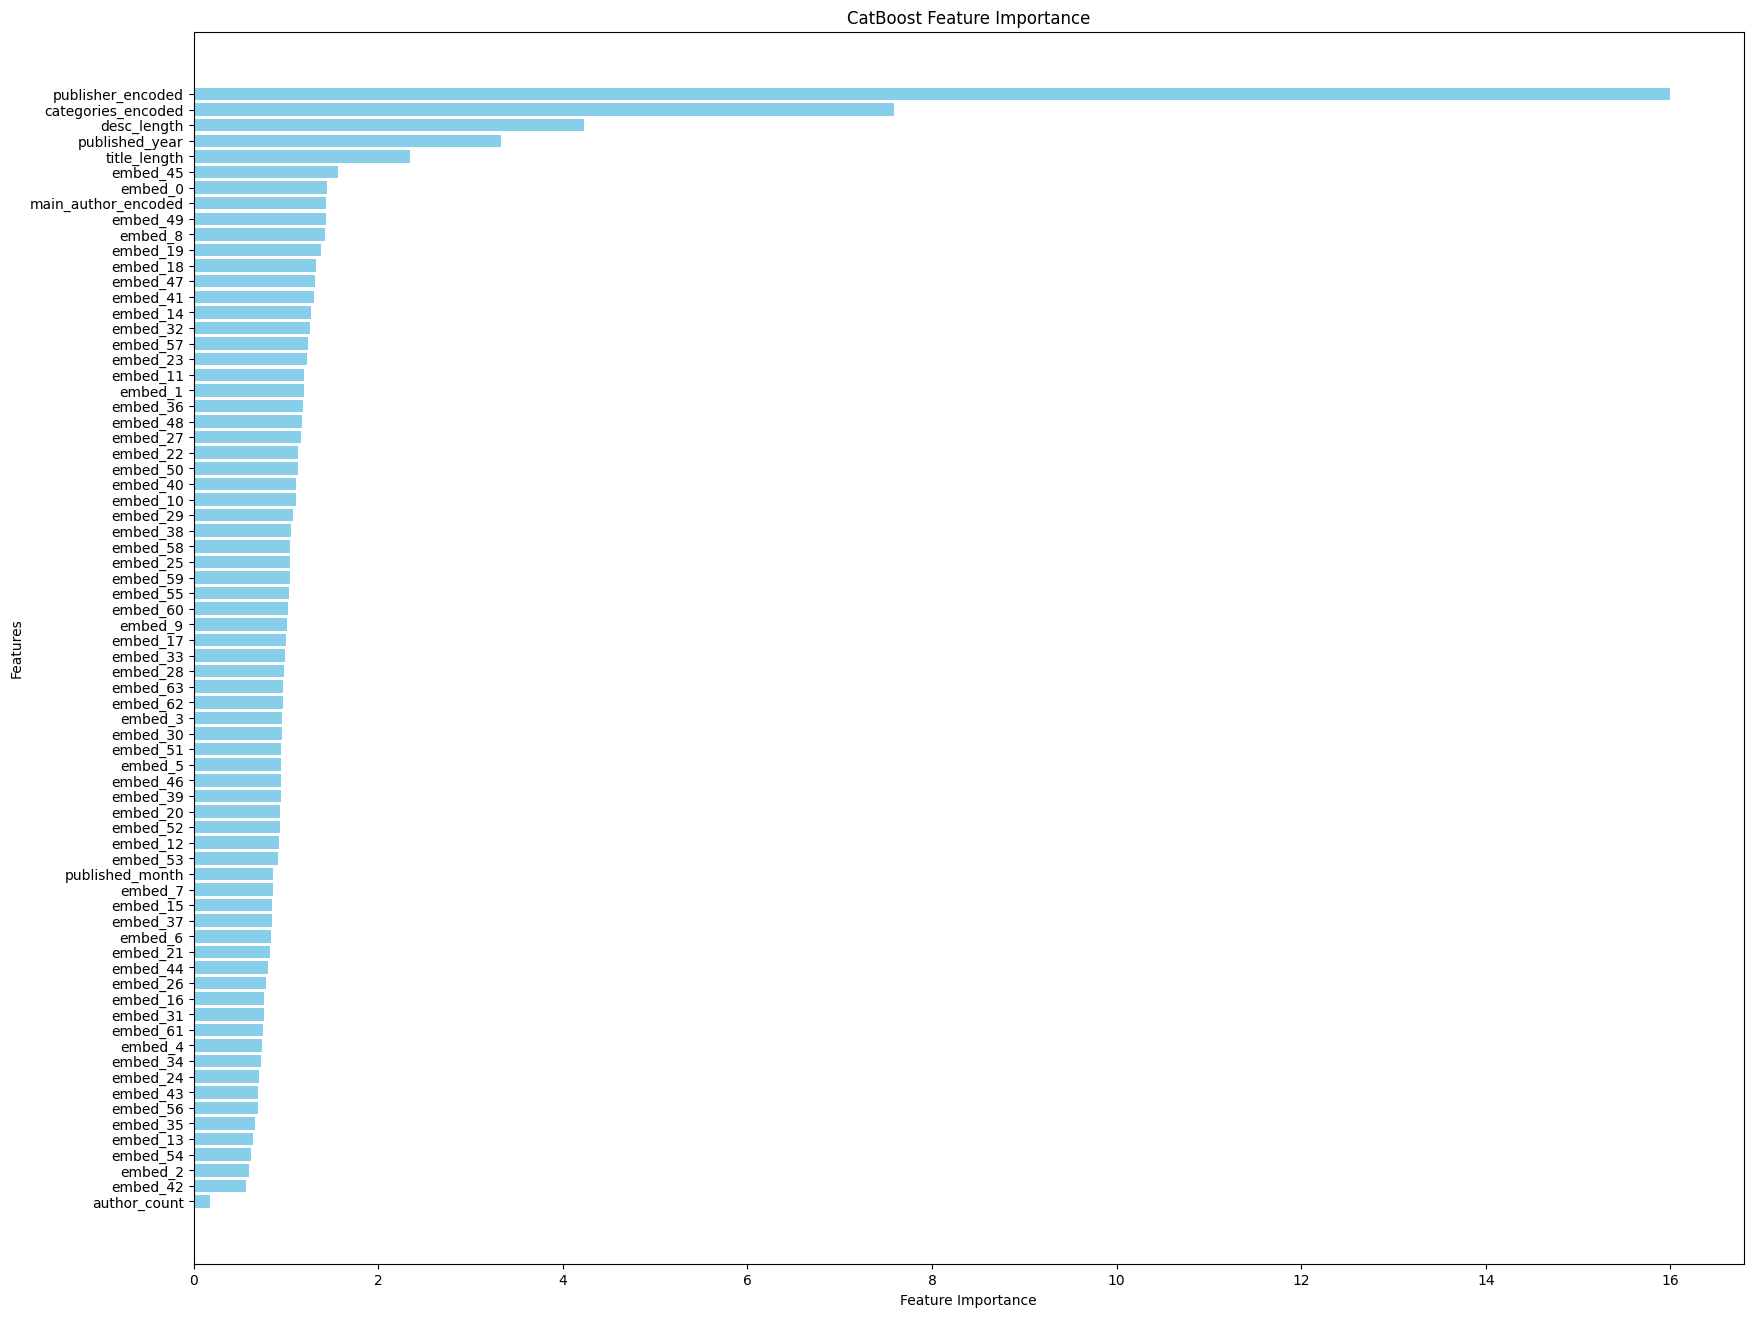

In [10]:
train_data = Pool(X, y, cat_features=cat_features)


model = CatBoostRegressor(iterations=1000, random_state=42)
model.fit(train_data,early_stopping_rounds=50,verbose=False)

feature_importance = model.get_feature_importance()
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 16))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()  
plt.show()
